In [ ]:
import numpy as np
import pandas as pd

from PIL import Image
import argparse
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.models as models
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Embedding
from keras.callbacks import ModelCheckpoint

# Data

In [ ]:
file_path = ''

def load_data():
    train_df = pd.read_csv(file_path + 'train.csv')
    test_df = pd.read_csv(file_path + 'test.csv')
    return train_df, test_df

In [ ]:
train_df, test_df = load_data()
data_size = len(train_df)
print(data_size)

train_df = train_df[train_df.category != 'Free Gifts']
data_size = len(train_df)
print(data_size)

categories = train_df.category.unique()
category_d = {k: v for v, k in enumerate(categories)}

assert(len(categories) == 26)

genders = train_df.gender.unique()
gender_d = {k: v for v, k in enumerate(genders)}
num_genders = len(genders)

baseColours = train_df.baseColour.unique()
baseColour_d = {k: v for v, k in enumerate(baseColours)}
num_baseColours = len(baseColours)

print('number of colors:', len(baseColours))

seasons = train_df.season.unique()
season_d = {k: v for v, k in enumerate(seasons)}
num_seasons = len(seasons)

usages = train_df.usage.unique()
usage_d = {k: v for v, k in enumerate(usages)}
num_usages = len(usages)

print('number of usages:', len(usages))


# training data

train_df.replace(
    {'category': category_d,
     'gender': gender_d,
     'baseColour': baseColour_d,
     'season': season_d,
     'usage': usage_d}
    , inplace=True
)

# testing data

test_df.replace(
    {'category': category_d,
     'gender': gender_d,
     'baseColour': baseColour_d,
     'season': season_d,
     'usage': usage_d}
    , inplace=True
)

21627
21566
number of colors: 46
number of usages: 7


In [ ]:
# 46 + 7 + 4 + 2 = 59

## Process Categorical Data

In [ ]:
def to_onehot(labels, num_labels):
    b = np.zeros((labels.size, num_labels))
    b[np.arange(labels.size),labels] = 1
    return b

In [ ]:
'''
num_genders = len(genders)
num_baseColours = len(baseColours)
num_seasons = len(seasons)
num_usages = len(usages)
'''

train_genders = train_df.gender.values
test_genders = test_df.gender.values

train_baseColours = train_df.baseColour.values
test_baseColours = test_df.baseColour.values

train_seasons = train_df.season.values
test_seasons = test_df.season.values

train_usages = train_df.usage.values
test_usages = test_df.usage.values

In [ ]:
image_predict = torch.load('prob_result_image_train.pt')
text_predict = torch.load('prob_result_text_train.pt')
targets = (train_df.category.values)

In [ ]:
assert(len(text_predict) == data_size)
assert(len(image_predict) == data_size)
assert(len(targets) == data_size)

In [ ]:
indices = np.random.permutation(data_size)

image_predict = image_predict[indices]
text_predict = text_predict[indices]
targets = targets[indices]

train_genders = to_onehot(train_genders[indices], num_genders)
test_genders = to_onehot(test_genders, num_genders)

train_baseColours = to_onehot(train_baseColours[indices], num_baseColours)
test_baseColours = to_onehot(test_baseColours, num_baseColours)

train_seasons = to_onehot(train_seasons[indices], num_seasons)
test_seasons = to_onehot(test_seasons, num_seasons)

train_usages = to_onehot(train_usages[indices], num_usages)
test_usages = to_onehot(test_usages, num_usages)

assert(len(train_genders) == len(train_baseColours))

train_cat = np.hstack((train_genders, train_baseColours, train_seasons, train_usages))

print(train_cat.shape)

train_x = torch.cat((image_predict, text_predict), 1).numpy()
train_y = targets

splits_cat = np.array_split(train_cat, 5)
splits_x = np.array_split(train_x, 5)
splits_y = np.array_split(targets, 5)



train_data_cat1 = torch.tensor(np.concatenate(np.delete(splits_cat, 4, 0)), dtype=torch.float32)
train_data_x1 = np.concatenate(np.delete(splits_x, 4, 0))
train_data_y1 = np.concatenate(np.delete(splits_y, 4, 0))

validation_data_cat1 = torch.tensor(splits_cat[4], dtype=torch.float32)
validation_data_x1 = splits_x[4]
validation_data_y1 = splits_y[4]

train_data_cat2 = torch.tensor(np.concatenate(np.delete(splits_cat, 3, 0)), dtype=torch.float32)
train_data_x2 = np.concatenate(np.delete(splits_x, 3, 0))
train_data_y2 = np.concatenate(np.delete(splits_y, 3, 0))

validation_data_cat2 = torch.tensor(splits_cat[3], dtype=torch.float32)
validation_data_x2 = splits_x[3]
validation_data_y2 = splits_y[3]

train_data_cat3 = torch.tensor(np.concatenate(np.delete(splits_cat, 2, 0)), dtype=torch.float32)
train_data_x3 = np.concatenate(np.delete(splits_x, 2, 0))
train_data_y3 = np.concatenate(np.delete(splits_y, 2, 0))

validation_data_cat3 = torch.tensor(splits_cat[2], dtype=torch.float32)
validation_data_x3 = splits_x[2]
validation_data_y3 = splits_y[2]

train_data_cat4 = torch.tensor(np.concatenate(np.delete(splits_cat, 1, 0)), dtype=torch.float32)
train_data_x4 = np.concatenate(np.delete(splits_x, 1, 0))
train_data_y4 = np.concatenate(np.delete(splits_y, 1, 0))

validation_data_cat4 =  torch.tensor(splits_cat[1], dtype=torch.float32)
validation_data_x4 = splits_x[1]
validation_data_y4 = splits_y[1]

train_data_cat5 = torch.tensor(np.concatenate(np.delete(splits_cat, 0, 0)), dtype=torch.float32)
train_data_x5 = np.concatenate(np.delete(splits_x, 0, 0))
train_data_y5 = np.concatenate(np.delete(splits_y, 0, 0))

validation_data_cat5 =  torch.tensor(splits_cat[0], dtype=torch.float32)
validation_data_x5 = splits_x[0]
validation_data_y5 = splits_y[0]

(21566, 62)


In [ ]:
# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

batch_size = 64
log_interval = 100

In [ ]:
class Cat_Dataset(Dataset):

    def __init__(self, data1, data2, target):
        self.data1 = data1
        self.data2 = data2
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()

        return self.data1[idx], self.data2[idx], self.target[idx]

In [ ]:
# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train1 = Cat_Dataset(train_data_cat1, train_data_x1, train_data_y1)
validation1 = Cat_Dataset(validation_data_cat1, validation_data_x1, validation_data_y1)

train2 = Cat_Dataset(train_data_cat2, train_data_x2, train_data_y2)
validation2 = Cat_Dataset(validation_data_cat2, validation_data_x2, validation_data_y2)

train3 = Cat_Dataset(train_data_cat3, train_data_x3, train_data_y3)
validation3 = Cat_Dataset(validation_data_cat3, validation_data_x3, validation_data_y3)

train4 = Cat_Dataset(train_data_cat4, train_data_x4, train_data_y4)
validation4 = Cat_Dataset(validation_data_cat4, validation_data_x4, validation_data_y4)

train5 = Cat_Dataset(train_data_cat5, train_data_x5, train_data_y5)
validation5 = Cat_Dataset(validation_data_cat5, validation_data_x5, validation_data_y5)



train_loader1 = DataLoader(train1, batch_size=batch_size, shuffle=True, **kwargs)
validation_loader1 = DataLoader(validation1, batch_size=batch_size, shuffle=True, **kwargs)

train_loader2 = DataLoader(train2, batch_size=batch_size, shuffle=True, **kwargs)
validation_loader2 = DataLoader(validation2, batch_size=batch_size, shuffle=True, **kwargs)

train_loader3 = DataLoader(train3, batch_size=batch_size, shuffle=True, **kwargs)
validation_loader3 = DataLoader(validation3, batch_size=batch_size, shuffle=True, **kwargs)

train_loader4 = DataLoader(train4, batch_size=batch_size, shuffle=True, **kwargs)
validation_loader4 = DataLoader(validation4, batch_size=batch_size, shuffle=True, **kwargs)

train_loader5 = DataLoader(train5, batch_size=batch_size, shuffle=True, **kwargs)
validation_loader5 = DataLoader(validation5, batch_size=batch_size, shuffle=True, **kwargs)

# Model

In [ ]:
input_size1 = num_genders + num_baseColours + num_seasons + num_usages
input_size2 = 52
num_classes = 26

class model_combine(nn.Module):
    def __init__(self, input_size1, input_size2, num_classes):
        super(model_combine, self).__init__()

        interim_size = 12

        self.layers1 = nn.Sequential(
            nn.Linear(input_size1, 27),
            #################
            
            ######################
            nn.ReLU(),
            nn.BatchNorm1d(27),
            #nn.Dropout(p=0.3),
            #nn.Linear(42, 32),
            #nn.ReLU(),
            nn.Dropout(),
            nn.Linear(27, interim_size)
        )

        self.layers2 = nn.Sequential(
            nn.Linear(interim_size + input_size2, 45),
            #############################
            
            ############################
            nn.ReLU(),
            nn.BatchNorm1d(45),
            #nn.Dropout(p=0.3),
            nn.Linear(45, 35),
            #################
            
            #################
            nn.ReLU(),
            nn.BatchNorm1d(35),
            nn.Dropout(),
            nn.Linear(35, num_classes)
        )

    def forward(self, input1, input2):
        x = self.layers1(input1)
        combined = torch.cat((x, input2), 1)
        output = self.layers2(combined)
        return output

model1 = model_combine(input_size1, input_size2, num_classes)
model2 = model_combine(input_size1, input_size2, num_classes)
model3 = model_combine(input_size1, input_size2, num_classes)
model4 = model_combine(input_size1, input_size2, num_classes)
model5 = model_combine(input_size1, input_size2, num_classes)

# Loss Function

In [ ]:
criterion1 = nn.CrossEntropyLoss(reduction='sum')
criterion2 = nn.CrossEntropyLoss(reduction='sum')
criterion3 = nn.CrossEntropyLoss(reduction='sum')
criterion4 = nn.CrossEntropyLoss(reduction='sum')
criterion5 = nn.CrossEntropyLoss(reduction='sum')

# Optimizer

In [ ]:
optimizer1 = optim.Adam(model1.parameters(), lr=8e-4)
optimizer2 = optim.Adam(model2.parameters(), lr=8e-4)
optimizer3 = optim.Adam(model3.parameters(), lr=8e-4)
optimizer4 = optim.Adam(model4.parameters(), lr=8e-4)
optimizer5 = optim.Adam(model5.parameters(), lr=8e-4)

# Training

In [ ]:
def model_train(epoch, model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        
        data1 = data1.to(device)
        data2 = data2.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        recon_batch = model(data1, data2)
        
        loss = criterion(recon_batch, targets)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(targets), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(targets)))

    average_loss = total_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_loss))
    return average_loss

# Testing

In [ ]:
def model_test(epoch, model, criterion, validation_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _, (data1, data2, targets) in enumerate(validation_loader):
            data1 = data1.to(device)
            data2 = data2.to(device)
            targets = targets.to(device)
            recon_batch = model(data1, data2)
            test_loss += criterion(recon_batch, targets).item()
            
            preds = recon_batch.argmax(dim=1)#, keepdim=True)
            correct += preds.eq(targets).sum().item()
            

    average_test_loss = test_loss / len(validation_loader.dataset)
    test_accuracy = correct / len(validation_loader.dataset)
    print('====> Validation loss: {:.4f}'.format(average_test_loss))
    print('====> Validation accuracy: {:.2f}'.format(test_accuracy))
    return average_test_loss

# Main

In [ ]:
epochs = 39

## Model1

Train Epoch: 1 [0/17253 (0%)]	Loss: 3.763608
Train Epoch: 1 [6400/17253 (37%)]	Loss: 0.885674
Train Epoch: 1 [12800/17253 (74%)]	Loss: 0.478159
====> Epoch: 1 Average loss: 0.9228
====> Validation loss: 0.1323
====> Validation accuracy: 0.99
Train Epoch: 2 [0/17253 (0%)]	Loss: 0.237712
Train Epoch: 2 [6400/17253 (37%)]	Loss: 0.207628
Train Epoch: 2 [12800/17253 (74%)]	Loss: 0.092540
====> Epoch: 2 Average loss: 0.1778
====> Validation loss: 0.0334
====> Validation accuracy: 1.00
Train Epoch: 3 [0/17253 (0%)]	Loss: 0.117243
Train Epoch: 3 [6400/17253 (37%)]	Loss: 0.081339
Train Epoch: 3 [12800/17253 (74%)]	Loss: 0.085792
====> Epoch: 3 Average loss: 0.0873
====> Validation loss: 0.0182
====> Validation accuracy: 1.00
Train Epoch: 4 [0/17253 (0%)]	Loss: 0.099001
Train Epoch: 4 [6400/17253 (37%)]	Loss: 0.173763
Train Epoch: 4 [12800/17253 (74%)]	Loss: 0.011556
====> Epoch: 4 Average loss: 0.0567
====> Validation loss: 0.0136
====> Validation accuracy: 1.00
Train Epoch: 5 [0/17253 (0%)]	Lo

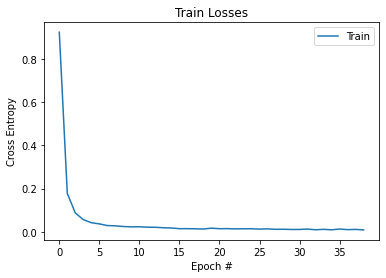

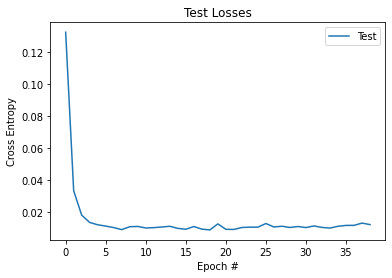

In [ ]:
average_train_losses = []
average_test_losses = []

model1 = model1.to(device)

for epoch in range(1, epochs + 1):
    average_train_loss = model_train(epoch, model1, optimizer1, criterion1, train_loader1)
    average_train_losses.append(average_train_loss)
    average_test_loss = model_test(epoch, model1, criterion1, validation_loader1)

    # save model with best validation loss
    if epoch == 1 or average_test_loss < min(average_test_losses):
        torch.save(model1, 'combine_with_cat_model1.pt')

    average_test_losses.append(average_test_loss)
    

# Plot Training Losses
plt.plot(average_train_losses)
plt.title('Train Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Train'], loc='upper right')
plt.show()

# Plot Testing Losses
plt.plot(average_test_losses)
plt.title('Test Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Test'], loc='upper right')
plt.show()

## Model2

Train Epoch: 1 [0/17253 (0%)]	Loss: 3.384395
Train Epoch: 1 [6400/17253 (37%)]	Loss: 0.766391
Train Epoch: 1 [12800/17253 (74%)]	Loss: 0.293612
====> Epoch: 1 Average loss: 0.8938
====> Validation loss: 0.1556
====> Validation accuracy: 0.99
Train Epoch: 2 [0/17253 (0%)]	Loss: 0.309622
Train Epoch: 2 [6400/17253 (37%)]	Loss: 0.164377
Train Epoch: 2 [12800/17253 (74%)]	Loss: 0.102982
====> Epoch: 2 Average loss: 0.1651
====> Validation loss: 0.0394
====> Validation accuracy: 1.00
Train Epoch: 3 [0/17253 (0%)]	Loss: 0.191540
Train Epoch: 3 [6400/17253 (37%)]	Loss: 0.083077
Train Epoch: 3 [12800/17253 (74%)]	Loss: 0.023125
====> Epoch: 3 Average loss: 0.0785
====> Validation loss: 0.0228
====> Validation accuracy: 1.00
Train Epoch: 4 [0/17253 (0%)]	Loss: 0.035670
Train Epoch: 4 [6400/17253 (37%)]	Loss: 0.016176
Train Epoch: 4 [12800/17253 (74%)]	Loss: 0.042892
====> Epoch: 4 Average loss: 0.0551
====> Validation loss: 0.0181
====> Validation accuracy: 1.00
Train Epoch: 5 [0/17253 (0%)]	Lo

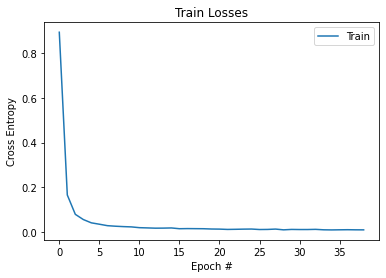

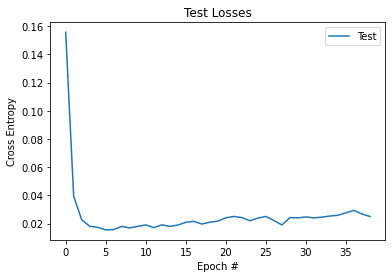

In [ ]:
average_train_losses = []
average_test_losses = []

model2 = model2.to(device)

for epoch in range(1, epochs + 1):
    average_train_loss = model_train(epoch, model2, optimizer2, criterion2, train_loader2)
    average_train_losses.append(average_train_loss)
    average_test_loss = model_test(epoch, model2, criterion2, validation_loader2)

    # save model with best validation loss
    if epoch == 1 or average_test_loss < min(average_test_losses):
        torch.save(model2, 'combine_with_cat_model2.pt')

    average_test_losses.append(average_test_loss)
    

# Plot Training Losses
plt.plot(average_train_losses)
plt.title('Train Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Train'], loc='upper right')
plt.show()

# Plot Testing Losses
plt.plot(average_test_losses)
plt.title('Test Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Test'], loc='upper right')
plt.show()

## Model3

Train Epoch: 1 [0/17253 (0%)]	Loss: 3.496244
Train Epoch: 1 [6400/17253 (37%)]	Loss: 0.846967
Train Epoch: 1 [12800/17253 (74%)]	Loss: 0.355944
====> Epoch: 1 Average loss: 0.8963
====> Validation loss: 0.1414
====> Validation accuracy: 0.99
Train Epoch: 2 [0/17253 (0%)]	Loss: 0.216561
Train Epoch: 2 [6400/17253 (37%)]	Loss: 0.193138
Train Epoch: 2 [12800/17253 (74%)]	Loss: 0.133860
====> Epoch: 2 Average loss: 0.1715
====> Validation loss: 0.0376
====> Validation accuracy: 1.00
Train Epoch: 3 [0/17253 (0%)]	Loss: 0.092764
Train Epoch: 3 [6400/17253 (37%)]	Loss: 0.169495
Train Epoch: 3 [12800/17253 (74%)]	Loss: 0.050798
====> Epoch: 3 Average loss: 0.0843
====> Validation loss: 0.0213
====> Validation accuracy: 1.00
Train Epoch: 4 [0/17253 (0%)]	Loss: 0.035268
Train Epoch: 4 [6400/17253 (37%)]	Loss: 0.032279
Train Epoch: 4 [12800/17253 (74%)]	Loss: 0.039850
====> Epoch: 4 Average loss: 0.0534
====> Validation loss: 0.0178
====> Validation accuracy: 1.00
Train Epoch: 5 [0/17253 (0%)]	Lo

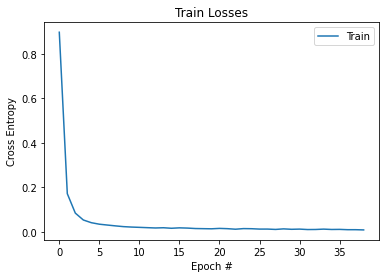

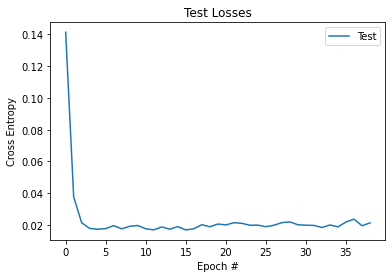

In [ ]:
average_train_losses = []
average_test_losses = []

model3 = model3.to(device)

for epoch in range(1, epochs + 1):
    average_train_loss = model_train(epoch, model3, optimizer3, criterion3, train_loader3)
    average_train_losses.append(average_train_loss)
    average_test_loss = model_test(epoch, model3, criterion3, validation_loader3)

    # save model with best validation loss
    if epoch == 1 or average_test_loss < min(average_test_losses):
        torch.save(model3, 'combine_with_cat_model3.pt')

    average_test_losses.append(average_test_loss)
    

# Plot Training Losses
plt.plot(average_train_losses)
plt.title('Train Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Train'], loc='upper right')
plt.show()

# Plot Testing Losses
plt.plot(average_test_losses)
plt.title('Test Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Test'], loc='upper right')
plt.show()

## Model4

Train Epoch: 1 [0/17253 (0%)]	Loss: 3.711555
Train Epoch: 1 [6400/17253 (37%)]	Loss: 0.767982
Train Epoch: 1 [12800/17253 (74%)]	Loss: 0.490966
====> Epoch: 1 Average loss: 0.9895
====> Validation loss: 0.1593
====> Validation accuracy: 0.99
Train Epoch: 2 [0/17253 (0%)]	Loss: 0.229323
Train Epoch: 2 [6400/17253 (37%)]	Loss: 0.168188
Train Epoch: 2 [12800/17253 (74%)]	Loss: 0.281736
====> Epoch: 2 Average loss: 0.1786
====> Validation loss: 0.0468
====> Validation accuracy: 1.00
Train Epoch: 3 [0/17253 (0%)]	Loss: 0.116298
Train Epoch: 3 [6400/17253 (37%)]	Loss: 0.111382
Train Epoch: 3 [12800/17253 (74%)]	Loss: 0.043436
====> Epoch: 3 Average loss: 0.0855
====> Validation loss: 0.0275
====> Validation accuracy: 1.00
Train Epoch: 4 [0/17253 (0%)]	Loss: 0.021876
Train Epoch: 4 [6400/17253 (37%)]	Loss: 0.027241
Train Epoch: 4 [12800/17253 (74%)]	Loss: 0.032312
====> Epoch: 4 Average loss: 0.0549
====> Validation loss: 0.0236
====> Validation accuracy: 1.00
Train Epoch: 5 [0/17253 (0%)]	Lo

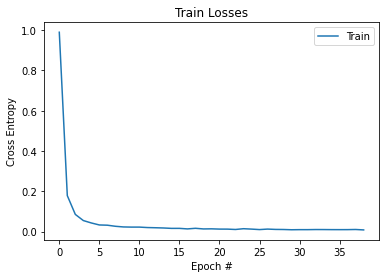

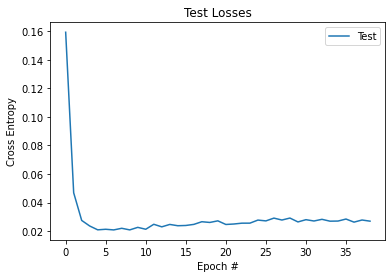

In [ ]:
average_train_losses = []
average_test_losses = []

model4 = model4.to(device)

for epoch in range(1, epochs + 1):
    average_train_loss = model_train(epoch, model4, optimizer4, criterion4, train_loader4)
    average_train_losses.append(average_train_loss)
    average_test_loss = model_test(epoch, model4, criterion4, validation_loader4)

    # save model with best validation loss
    if epoch == 1 or average_test_loss < min(average_test_losses):
        torch.save(model4, 'combine_with_cat_model4.pt')

    average_test_losses.append(average_test_loss)
    

# Plot Training Losses
plt.plot(average_train_losses)
plt.title('Train Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Train'], loc='upper right')
plt.show()

# Plot Testing Losses
plt.plot(average_test_losses)
plt.title('Test Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Test'], loc='upper right')
plt.show()

## Model5

Train Epoch: 1 [0/17252 (0%)]	Loss: 3.715882
Train Epoch: 1 [6400/17252 (37%)]	Loss: 1.015585
Train Epoch: 1 [12800/17252 (74%)]	Loss: 0.335324
====> Epoch: 1 Average loss: 0.9888
====> Validation loss: 0.1366
====> Validation accuracy: 0.99
Train Epoch: 2 [0/17252 (0%)]	Loss: 0.224904
Train Epoch: 2 [6400/17252 (37%)]	Loss: 0.168531
Train Epoch: 2 [12800/17252 (74%)]	Loss: 0.069422
====> Epoch: 2 Average loss: 0.1720
====> Validation loss: 0.0354
====> Validation accuracy: 1.00
Train Epoch: 3 [0/17252 (0%)]	Loss: 0.070723
Train Epoch: 3 [6400/17252 (37%)]	Loss: 0.031838
Train Epoch: 3 [12800/17252 (74%)]	Loss: 0.070715
====> Epoch: 3 Average loss: 0.0834
====> Validation loss: 0.0184
====> Validation accuracy: 1.00
Train Epoch: 4 [0/17252 (0%)]	Loss: 0.046067
Train Epoch: 4 [6400/17252 (37%)]	Loss: 0.041246
Train Epoch: 4 [12800/17252 (74%)]	Loss: 0.112861
====> Epoch: 4 Average loss: 0.0533
====> Validation loss: 0.0154
====> Validation accuracy: 1.00
Train Epoch: 5 [0/17252 (0%)]	Lo

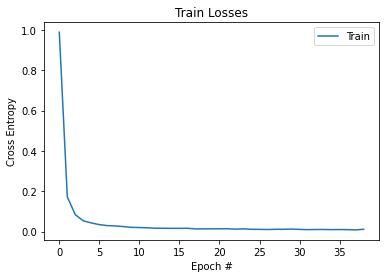

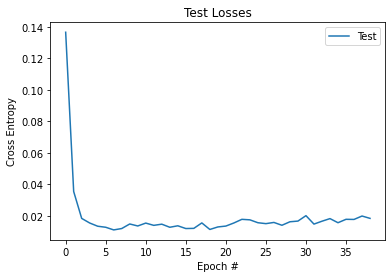

In [ ]:
average_train_losses = []
average_test_losses = []

model5 = model5.to(device)

for epoch in range(1, epochs + 1):
    average_train_loss = model_train(epoch, model5, optimizer5, criterion5, train_loader5)
    average_train_losses.append(average_train_loss)
    average_test_loss = model_test(epoch, model5, criterion5, validation_loader5)

    # save model with best validation loss
    if epoch == 1 or average_test_loss < min(average_test_losses):
        torch.save(model5, 'combine_with_cat_model5.pt')

    average_test_losses.append(average_test_loss)
    

# Plot Training Losses
plt.plot(average_train_losses)
plt.title('Train Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Train'], loc='upper right')
plt.show()

# Plot Testing Losses
plt.plot(average_test_losses)
plt.title('Test Losses')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Test'], loc='upper right')
plt.show()

# Predict Result for Test Data

In [ ]:
model_path = ''

model1 = torch.load(model_path + 'combine_with_cat_model1.pt')
model1 = model1.to(device)
model1.eval()

model2 = torch.load(model_path + 'combine_with_cat_model2.pt')
model2 = model2.to(device)
model2.eval()

model3 = torch.load(model_path + 'combine_with_cat_model3.pt')
model3 = model3.to(device)
model3.eval()

model4 = torch.load(model_path + 'combine_with_cat_model4.pt')
model4 = model4.to(device)
model4.eval()

model5 = torch.load(model_path + 'combine_with_cat_model5.pt')
model5 = model5.to(device)
model5.eval()

image_predict_result = torch.load('prob_result_image.pt')
text_predict_result = torch.load('prob_result_text.pt')

test_data = torch.cat((image_predict_result, text_predict_result), 1).to(device) #.numpy()

test_cat = torch.tensor(np.hstack((test_genders, test_baseColours, test_seasons, test_usages)), dtype=torch.float32).to(device)

assert(len(test_data) == len(test_cat))

with torch.no_grad():

    pred1 = model1(test_cat, test_data)
    pred2 = model2(test_cat, test_data)
    pred3 = model3(test_cat, test_data)
    pred4 = model4(test_cat, test_data)
    pred5 = model5(test_cat, test_data)

    prediction = (nn.Softmax(dim=1)(pred1) + nn.Softmax(dim=1)(pred2) + nn.Softmax(dim=1)(pred3)
                       + nn.Softmax(dim=1)(pred4) + nn.Softmax(dim=1)(pred5))

    prob_result = prediction.cpu()

    prediction1 = prob_result.argmax(dim=1)

    test_df['category'] = categories[prediction1.numpy()]

    '''labels = [pred1.argmax(dim=1).item(), pred2.argmax(dim=1).item(), pred3.argmax(dim=1).item(),
                  pred4.argmax(dim=1).item(), pred5.argmax(dim=1).item()]

        unique_labels, counts = np.unique(labels, return_counts=True)
        best_index = np.argmax(counts)
        prediction2 = unique_labels[best_index]'''


headers = ['id', 'category']

result = test_df[headers].values

predict = pd.DataFrame(result, columns=headers)

print(predict)

predict.to_csv('submission_combine_neuron_with_cat_ic.csv', index=False)
        

          id   category
0      26266  Innerwear
1      22134    Topwear
2      28358      Belts
3      15554      Shoes
4      53408  Innerwear
...      ...        ...
21623  39737    Eyewear
21624  57477      Dress
21625  22312    Topwear
21626  54105       Lips
21627  14080       Bags

[21628 rows x 2 columns]
